# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [77]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

  Using cached networkx-2.1-py2.py3-none-any.whl
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)


In [78]:
nx.__version__ # should be 2.1

'2.1'

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue

%matplotlib inline

In [80]:
plt.rcParams['figure.figsize'] = 14, 14

## Step 1 - Load Data

In [81]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [82]:
xmin = np.min(data[:, 0] - data[:, 3])
xmax = np.max(data[:, 0] + data[:, 3])

ymin = np.min(data[:, 1] - data[:, 4])
ymax = np.max(data[:, 1] + data[:, 4])

zmin = 0
# Limit the z axis for the visualization
zmax = 10

print("X")
print("min = {0}, max = {1}\n".format(xmin, xmax))

print("Y")
print("min = {0}, max = {1}\n".format(ymin, ymax))

print("Z")
print("min = {0}, max = {1}".format(zmin, zmax))

X
min = -315.2389, max = 604.7611

Y
min = -444.2315, max = 475.7685

Z
min = 0, max = 10


In [83]:
def extract_polygons(data):

    polygons = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        
        northMin = (north - d_north)
        northMax = (north + d_north)
        eastMin = (east - d_east)
        eastMax = (east + d_east)
        altMin = (alt - d_alt)
        altMax = (alt + d_alt)
        
        # Extract the 4 corners of the obstacle
        # 
        # NOTE: The order of the points matters since
        # `shapely` draws the sequentially from point to point.
        #
        # If the area of the polygon is 0 you've likely got a weird
        # order.
        corners = [(northMin, eastMin),  (northMax, eastMax), (northMax, eastMin), (northMin, eastMax)]
        
        # Compute the height of the polygon
        height = altMax - altMin

        # Once you've defined corners, define polygons
        p = Polygon(corners)
        polygons.append((p, height))

    return polygons

In [84]:
polygons = extract_polygons(data)

## Step 2 - Sample Points


You may want to limit the z-axis values.

In [123]:
from sklearn.neighbors import KDTree

colliderPoints = []
for collider in data:
    colliderPoints.append((collider[0], collider[1], collider[2]))
collisionTree = KDTree(colliderPoints)

num_samples = 1000
xvals = np.random.uniform(xmin, xmax, num_samples)
yvals = np.random.uniform(ymin, ymax, num_samples)
zvals = np.random.uniform(zmin, zmax, num_samples)
samples = list(zip(xvals, yvals, zvals))

def collides(polygon, point):   
    p, height = polygon
    if p.contains(Point(point[0], point[1])) and point[2] <= height:
        return True
    return False

to_keep = []
to_discard = []
for point in samples:
    idxes = collisionTree.query([point], k=1, return_distance=False)[0]
    polygon = polygons[idxes[0]]
    if not collides(polygon, point):
        to_keep.append(point)
    else:
        to_discard.append(point)


In [124]:
print(len(to_keep))
print(len(to_discard))

4458
542


## Points Visualization

In [125]:
from grid import create_grid
grid = create_grid(data, zmax, 1)

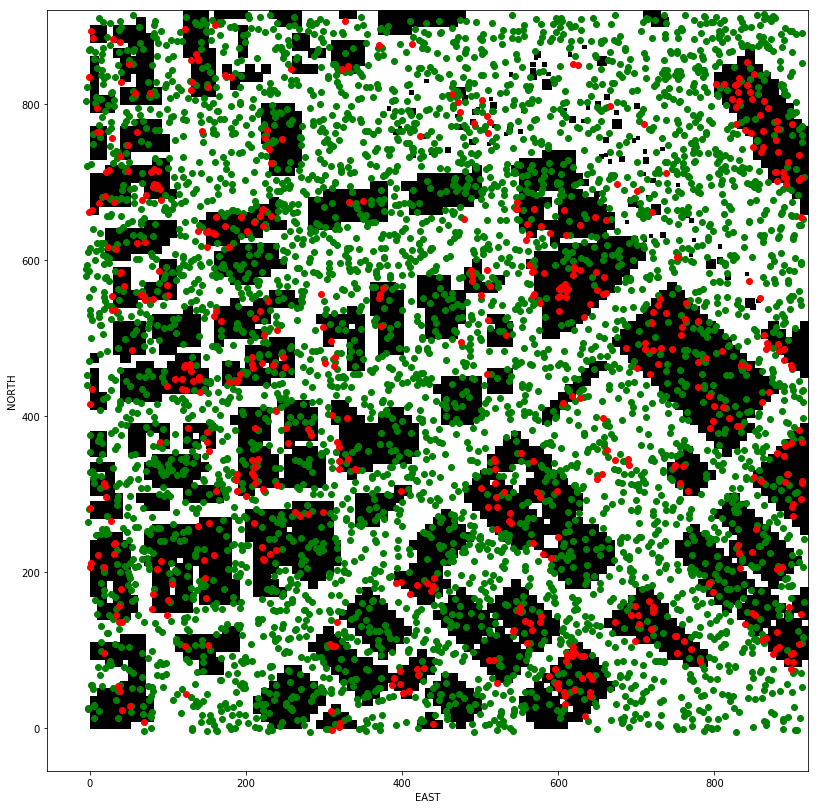

In [126]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw points
all_pts = np.array(to_keep)
north_vals = all_pts[:,0]
east_vals = all_pts[:,1]
plt.scatter(east_vals - emin, north_vals - nmin, c='green')

all_pts2 = np.array(to_discard)
north_vals2 = all_pts2[:,0]
east_vals2 = all_pts2[:,1]
plt.scatter(east_vals2 - emin, north_vals2 - nmin, c='red')

plt.ylabel('NORTH')
plt.xlabel('EAST')

plt.show()

## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [132]:
nodes = all_pts


g = nx.Graph()
for node in nodes:
    g.add_node((node[0], node[1], node[2]))
    
tree = KDTree(g.nodes)
    
for i, node in enumerate(nodes):
    nodeTuple = (node[0], node[1], node[2])
    # Get 3 nearest neighbors
    neighborIdxes = tree.query([nodeTuple], k=5, return_distance=False)[0]
    # Check if we can connect between these nodes. Find center point between the nodes
    # and distance between nodes. Find all polygons in this range and check collision.
    for neighborIdx in neighborIdxes:
        if neighborIdx == i:
            continue
        nodeNeighbor = nodes[neighborIdx]
        nodeNeighborTuple = (nodeNeighbor[0], nodeNeighbor[1], nodeNeighbor[2])
        potentialEdge = LineString([nodeTuple, nodeNeighborTuple])
        
        # Find center of this edge
        centerX = (nodeTuple[0] + nodeNeighborTuple[0]) / 2.0
        centerY = (nodeTuple[1] + nodeNeighborTuple[1]) / 2.0
        centerZ = (nodeTuple[2] + nodeNeighborTuple[2]) / 2.0
        center = (centerX, centerY, centerZ)
        length = potentialEdge.length
        
        # Find all polygons around this edge and check collision
        collides = False
        polygonIdxes = collisionTree.query_radius([center], r=length/2, return_distance=False)[0]
        for idx in polygonIdxes:
            p, height = polygons[idx]
            if potentialEdge.crosses(p):
                collides = True
        if not collides:
            g.add_edge(nodeTuple, nodeNeighborTuple)


## Step 4 - Visualize Graph

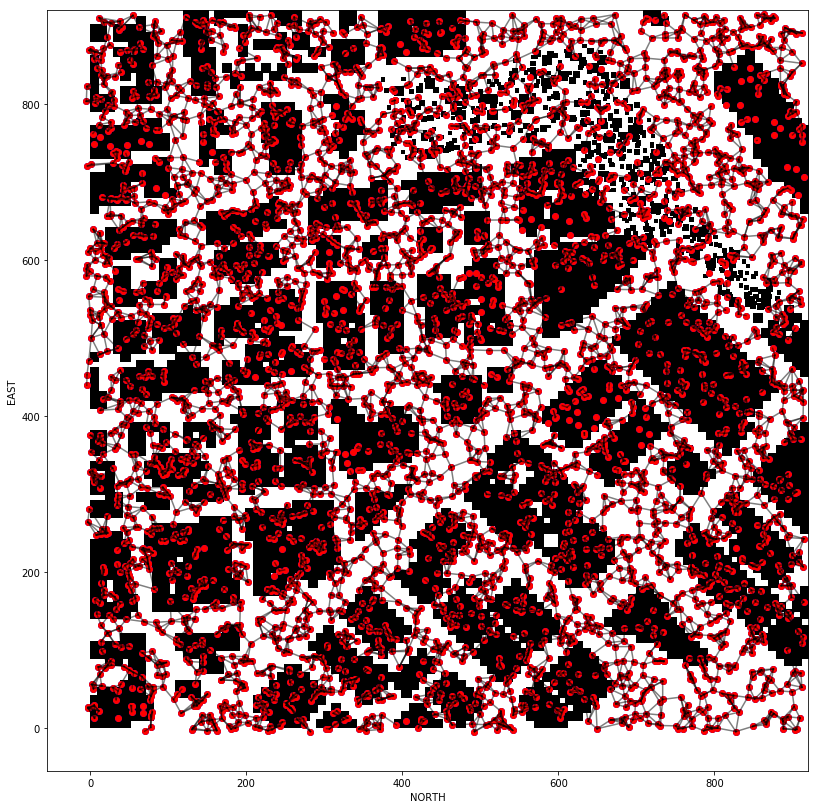

In [133]:
# Create a grid map of the world
from grid import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, 1, 1)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

In [157]:

print(g.number_of_nodes())
print(g.number_of_edges())

4458
9945


## Step 5 - Define Heuristic

In [175]:
def heuristic(p1, p2):
    return LineString([p1, p2]).length

## Step 6 - Complete A*

In [182]:
def a_star(graph, h, start, goal):

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = LineString([current_node, next_node]).length
                branch_cost = current_cost + cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


In [183]:
start_ne = (25,  100)
goal_ne = (750., 370.)

In [184]:
# Static drone altitude (metres)
drone_altitude = 5
safety_distance = 3

In [185]:
# Find closest point to a position
def closest_point(graph, current_point):
    closestPoint = None
    minDist = None
    for v in list(g.nodes):
        dist = heuristic([v[0], v[1]], [current_point[0], current_point[1]])
        if minDist == None or dist < minDist:
            closestPoint = v
            minDist = dist
    return closestPoint

In [186]:
# Snap start/end positions to a node
start_ne_g = closest_point(g, start_ne)
goal_ne_g = closest_point(g, goal_ne)
print(start_ne)
print(start_ne_g)
print(goal_ne)
print(goal_ne_g)

(25, 100)
(24.58565572071575, 101.10044102329323, 2.3278896101219857)
(750.0, 370.0)
(601.1471801727143, 362.6753584405109, 4.421005253791729)


In [187]:
# Use A* to compute path along the graph
path, cost = a_star(g, heuristic, start_ne_g, goal_ne_g)
print(len(path))

Found a path.
61


## Step 7 - Visualize Path

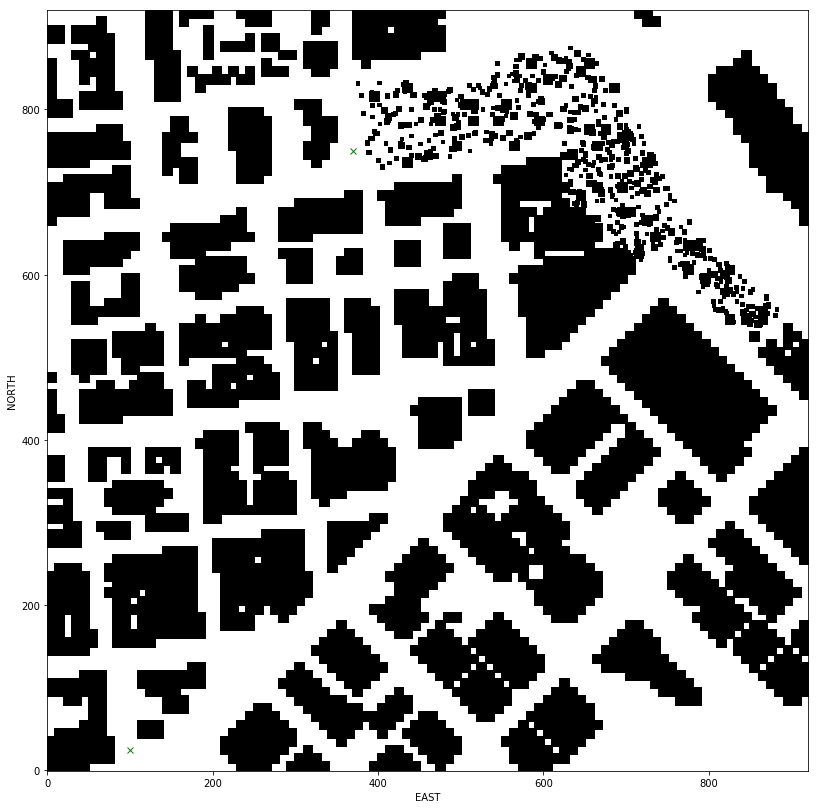

In [190]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'gx')
plt.plot(goal_ne[1], goal_ne[0], 'gx')
    
#if path is not None:
    #pp = np.array(path)
    #plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

[solution](/notebooks/Probabilistic-Roadmap-Solution.ipynb)